In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from copy import deepcopy
import glob, sys

[sys.path.append(f) for f in glob.glob('utils/*')]
from preprocess import *
from firingrate import raster2FR
from plotting_utils import *
from lineplots import plotsd
from hmm_utils import *
from stabilizer_utils import *
from recalibration_utils import *
from session_utils import *

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import FactorAnalysis, PCA



min_nblocks    = 3
max_ndays      = 1e23
min_R2         = 0.1

filedir        = glob.glob('D:/T5_ClosedLoop/*')
sessions_check = np.load('misc_data/sessions_check.npy', allow_pickle = True).item()
click_sessions = get_Sessions(filedir, min_nblocks = min_nblocks)  

init_pairs    = get_SessionPairs(files, max_ndays = max_ndays, manually_remove = sessions_check['bad_days'])
pairs, scores = get_StrongTransferPairs(init_pairs, min_R2 = min_R2, train_frac = 0.5, block_constraints = sessions_check)
n_pairs       = len(pairs)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
def getDistortionMatrix(dec, enc):
    '''
    Get distortion matrix D^T * E. Inputs are:
    
        dec (2D array) - n_channels x 2 array
        enc (2D array) - n_channels x 2 array 
    '''
    
    distort  = dec.T.dot(enc)
    distort /= np.outer(np.linalg.norm(dec, axis = 0), np.linalg.norm(enc, axis = 0))
    
    return distort

In [1]:
from CosineTuning import unit_vector, fitEncodingMatrix

# general settings:
np.random.seed(42)
diffs           = list()
task            = None
train_frac      = 0.5
sigma           = None

distortion_mats = np.zeros((n_pairs, 2, 2))
diffs           = np.zeros(n_pairs)

for i, (A_file, B_file) in enumerate(pairs):  
    dayA, dayB              = DataStruct(A_file, alignScreens = True), DataStruct(B_file, alignScreens = True)
    diffs[i]                = daysBetween(dayA.date, dayB.date) # record number of days between sessions

    dayA_blocks             = [sessions_check[A_file] if A_file in sessions_check.keys() else None][0]
    dayB_blocks             = [sessions_check[B_file] if B_file in sessions_check.keys() else None][0] 
    dayA_task, dayB_task, _ = getPairTasks(dayA, dayB, task = task)

     # obtain features and cursorError targets:
    Atrain_x, Atest_x, Atrain_y, Atest_y  = getTrainTest(dayA, train_frac = train_frac, sigma = sigma, blocks = dayA_blocks, task = dayA_task, return_flattened = True)
    Btrain_x, Btest_x, Btrain_y, Btest_y  = getTrainTest(dayB, train_frac = train_frac, sigma = sigma, blocks = dayB_blocks, task = dayB_task, return_flattened = True)
    
    enc                      = fitEncodingMatrix(Atrain_y, Atrain_x)
    full_score, B_decoder    = traintest_DecoderSupervised([Btrain_x], [Btrain_x], [Btrain_y], [Btrain_y], meanRecal = False)           # evaluate training set mean performance 

    distortion_mats[i, :, :] = getDistortionMatrix(B_decoder.coef_.T, enc.T)
    


ModuleNotFoundError: No module named 'CosineTuning'

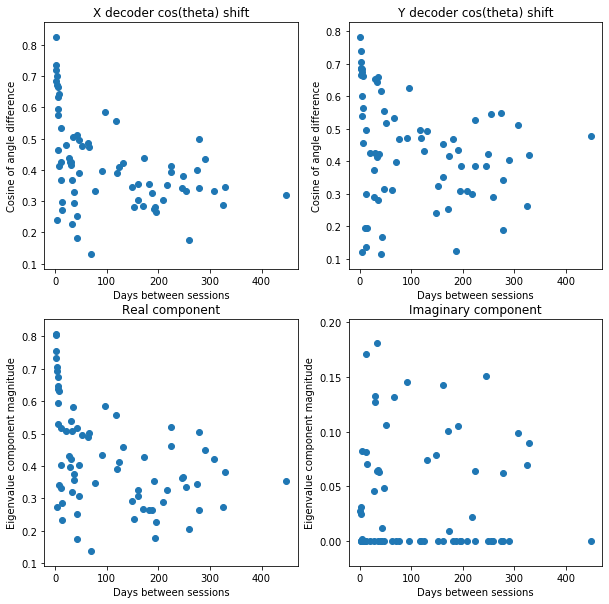

In [132]:
figSize(10, 10)

labels = ['X decoder cos(theta) shift', 'Y decoder cos(theta) shift']
for i, label in enumerate(labels):
    plt.subplot(2, 2, i + 1)
    plt.scatter(diffs, distortion_mats[:, i, i])
    plt.title(label)
    plt.xlabel('Days between sessions')
    plt.ylabel('Cosine of angle difference')
    

eigvals     = [np.linalg.eigvals(distortion_mats[i, :, :])[0] for i in range(n_pairs)]
eigval_comp = [np.real(eigvals), np.imag(eigvals)]

labels = ['Real component', 'Imaginary component']
for i, label in enumerate(labels):
    plt.subplot(2, 2, i + 3)
    plt.scatter(diffs, eigval_comp[i])
    plt.title(label)
    plt.xlabel('Days between sessions')
    plt.ylabel('Eigenvalue component magnitude')

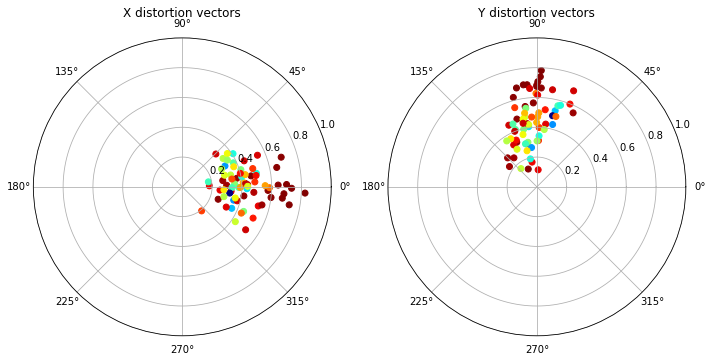

In [133]:
import matplotlib.cm as cm

labels = ['X distortion vectors', 'Y distortion vectors']

for i, lab in enumerate(labels):
    plt.subplot(1, 2, i + 1, projection='polar')
    
    theta = np.arctan2(distortion_mats[:, 1, i], distortion_mats[:, 0, i])
    r     = np.linalg.norm(distortion_mats[:, :, i], axis = 1)
    plt.scatter(theta, r, color = cm.jet(1 - (diffs / max(diffs))))
    ax = plt.gca()
    ax.set_rlim([0, 1])
    
    plt.title(lab)
    
plt.tight_layout()

### Look at encoder drift model

Now we'll fit a linear model of our encoder drift across days with the formula:

$E' = \alpha E + \epsilon \ \ \ $     where $\epsilon \sim N(0, \sigma^{2}) $

This will help us determine plausible parameters for the closed-loop simulator by figuring out good values for the *shrinkage factor* $\alpha$ and noise model. Once we get the shrinkage factors for each pair of sessions, we can then fit some 
canonical shrinkage factor per day that helps compare these data across pairs (each pair may have e.g. 2 or 200 days apart). In this updated model, we have that:

$E^{(n)} = a^{n} E_{0} + \epsilon \ \ \ $ where $\epsilon \sim N(0, \sigma^{2} n * (\alpha^{n-1})^{2}) $

We can get this base shrinkage $\alpha$ value by performing linear regression on the observed shrinkages in log-space:

$\alpha_{x} \approx \hat{\alpha} = \exp(c \cdot x )$

$c = argmin_{a_{0}} ||\log(\alpha_{x}) - x * log(\alpha_{0}) ||^{2} $

In [305]:
#We're interested in decay properties over 2 weeks; for some sessions there's weirdly high stability even 100's of days out but we're concerned with the subgroup of data points 
#where there's rapid decay in the first two weeks (look at plots in distortion matrix to see this streak)

min_nblocks    = 3
max_ndays      = 1e23
min_R2         = 0.1

init_pairs    = get_SessionPairs(files, min_nblocks = min_nblocks, max_ndays = max_ndays, manually_remove = sessions_check['bad_days'])
pairs, scores = get_StrongTransferPairs(init_pairs, min_R2 = min_R2, train_frac = 0.5, block_constraints = sessions_check)
n_pairs       = len(pairs)

In [306]:
from CosineTuning import unit_vector, fitEncodingMatrix

# general settings:
np.random.seed(42)
diffs           = list()
task            = None
train_frac      = 0.5
sigma           = None

shrinkages = np.zeros((n_pairs, ))
residuals  = np.zeros((n_pairs, 192 * 2))
diffs      = np.zeros((n_pairs, ))

for i, (A_file, B_file) in enumerate(pairs):  
    dayA, dayB              = DataStruct(A_file, alignScreens = True), DataStruct(B_file, alignScreens = True)
    diffs[i]                = daysBetween(dayA.date, dayB.date) # record number of days between sessions

    dayA_blocks             = [sessions_check[A_file] if A_file in sessions_check.keys() else None][0]
    dayB_blocks             = [sessions_check[B_file] if B_file in sessions_check.keys() else None][0] 
    dayA_task, dayB_task, _ = getPairTasks(dayA, dayB, task = task)

     # obtain features and cursorError targets:
    Atrain_x, Atest_x, Atrain_y, Atest_y  = getTrainTest(dayA, train_frac = train_frac, sigma = sigma, blocks = dayA_blocks, task = dayA_task, return_flattened = True)
    Btrain_x, Btest_x, Btrain_y, Btest_y  = getTrainTest(dayB, train_frac = train_frac, sigma = sigma, blocks = dayB_blocks, task = dayB_task, return_flattened = True)
    
    encA  = fitEncodingMatrix(Atrain_y, Atrain_x).T.flatten()
    encB  = fitEncodingMatrix(Btrain_y, Btrain_x).T.flatten()
    
    shrinkages[i] = np.linalg.lstsq(encA[:, np.newaxis], encB[:, np.newaxis], rcond = None)[0][0][0]
    residuals[i]  = encB - (shrinkages[i] * encA)

res_means = np.asarray([res.mean() for res in residuals])
res_vars  = np.asarray([np.var(res) for res in residuals])

utils\PD_tools\CosineTuning.py:41: RuntimeWarning: invalid value encountered in true_divide
  v1_u     = np.divide(v1_array, v1_norms[:, np.newaxis])


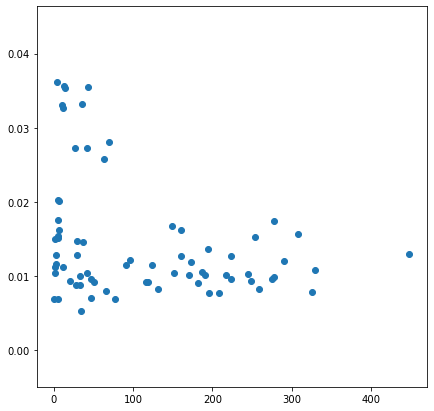

In [328]:
sigma_est = list()

for x, var in zip(diffs, res_vars):
    sigma_trl = var / ((alpha**(2 * x - 2)) * x)
    sigma_est.append(sigma_trl)
sigma_est = np.asarray(sigma_est)

var_hat = np.mean(sigma_est[sigma_est < 3])
    


x      = np.arange(1, max(diffs))
ypreds = x * var_hat * (alpha ** (2 * x - 2))

plt.scatter(diffs, res_vars)
#plt.plot(x, ypreds)

Base alpha =  0.9261583961038757


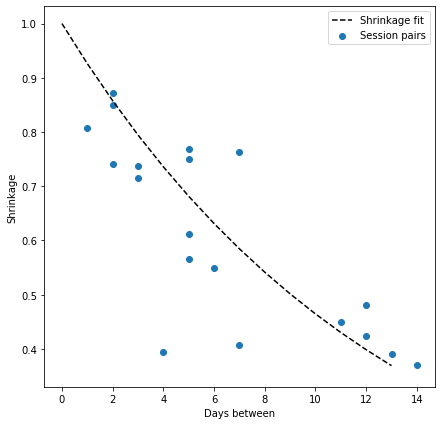

In [292]:
figSize(7, 7)
predx = np.vstack([diffs, np.ones(len(diffs))]).T

mult  = np.linalg.lstsq(diffs[:, np.newaxis], np.log(shrinkages)[:, np.newaxis], rcond = None)[0][0][0]
#mult, c  = np.linalg.lstsq(predx, np.log(shrinkages)[:, np.newaxis], rcond = None)[0]
alpha    = np.exp(mult)
print('Base alpha = ', alpha)

plt.scatter(diffs, shrinkages, label = 'Session pairs')
x     = np.arange(max(diffs))
ypred = np.exp(mult * x) 
#ypred = np.exp(mult * x) * np.exp(c)
plt.plot(x, ypred, color = 'k', linestyle = '--', label = 'Shrinkage fit')
plt.xlabel('Days between')
plt.ylabel('Shrinkage')
plt.legend()

### Now subsample channel counts and look at distortion matrix variability across days

In [9]:
channel_sweep = [10, 50, 100, 150, 180]
n_repeats     = 50



# general settings:
np.random.seed(42)
diffs           = list()
task            = None
train_frac      = 0.5
sigma           = None

distortion_mats = np.zeros((n_pairs, len(channel_sweep), n_repeats, 2, 2))
diffs           = np.zeros((n_pairs, ))

for i, (A_file, B_file) in enumerate(pairs):  
    dayA, dayB              = DataStruct(A_file, alignScreens = True), DataStruct(B_file, alignScreens = True)
    diffs[i]                = daysBetween(dayA.date, dayB.date) # record number of days between sessions

    dayA_blocks             = [sessions_check[A_file] if A_file in sessions_check.keys() else None][0]
    dayB_blocks             = [sessions_check[B_file] if B_file in sessions_check.keys() else None][0] 
    dayA_task, dayB_task, _ = getPairTasks(dayA, dayB, task = task)

     # obtain features and cursorError targets:
    Atrain_x, Atest_x, Atrain_y, Atest_y  = getTrainTest(dayA, train_frac = train_frac, sigma = sigma, blocks = dayA_blocks, task = dayA_task, return_flattened = True)
    Btrain_x, Btest_x, Btrain_y, Btest_y  = getTrainTest(dayB, train_frac = train_frac, sigma = sigma, blocks = dayB_blocks, task = dayB_task, return_flattened = True)
    enc                                   = fitEncodingMatrix(Atrain_y, Atrain_x).T
    
    for j, nchans in enumerate(channel_sweep):
        for k in range(n_repeats):
            chans       = np.random.choice(192, nchans, replace = True)
            enc_sub     = enc[chans, :]

            _, B_decSub = traintest_DecoderSupervised([Btrain_x[:, chans]], [Btrain_x[:, chans]], [Btrain_y], [Btrain_y], meanRecal = False)    

            distortion_mats[i, j, k,:, :] = getDistortionMatrix(B_decSub.coef_.T, enc_sub)
    print(i)

NameError: name 'fitEncodingMatrix' is not defined

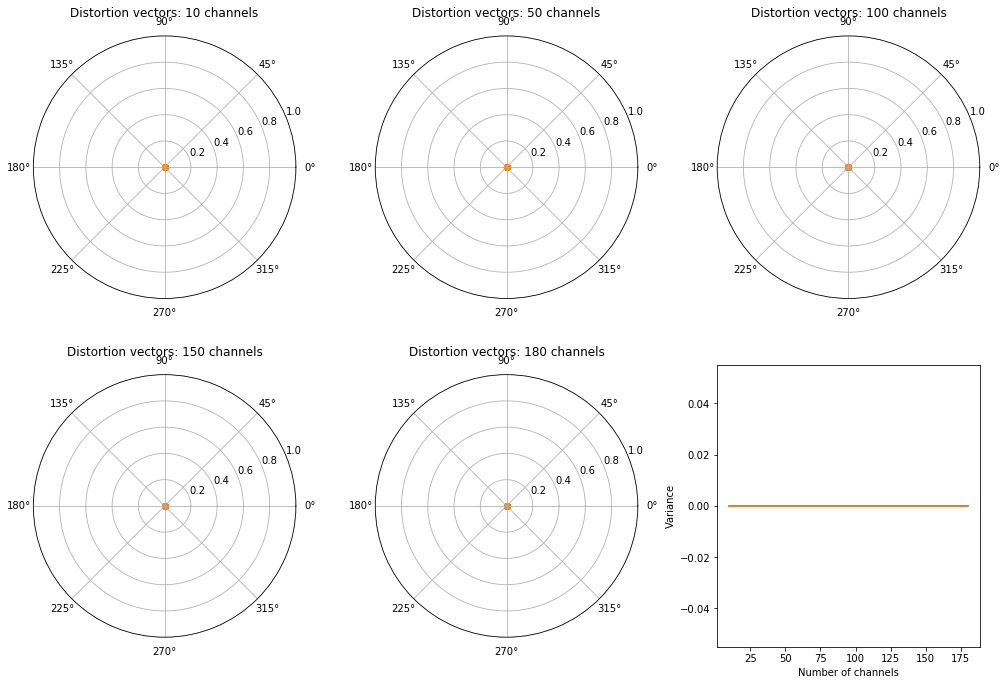

In [7]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt


figSize(14, 14)
pair   = 0

labels = ['X distortion vectors', 'Y distortion vectors']

for i, nUnits in enumerate(channel_sweep):
    plt.subplot(3, 3, i + 1, projection='polar')
    for j in range(2):
        theta = np.arctan2(distortion_mats[pair, i, :, 1, j], distortion_mats[pair, i, :, 0, j])
        r     = np.linalg.norm(distortion_mats[pair, i, :, :, j], axis = 1)
        plt.scatter(theta, r, )
        ax    = plt.gca()
        ax.set_rlim([0, 1])
    plt.title('Distortion vectors: ' + str(nUnits) + ' channels')
    
plt.subplot(3, 3, 6)
var_x = np.var(distortion_mats[pair, :, :, 1, 0], axis = 1)
var_y = np.var(distortion_mats[pair, :, :, 0, 1], axis = 1)

plt.plot(channel_sweep, var_x)
plt.plot(channel_sweep, var_y)
plt.xlabel('Number of channels')
plt.ylabel('Variance')
    
plt.tight_layout()

In [33]:
var_x

0.027320154320274584